<a href="https://colab.research.google.com/github/JonathanMartignon/ReconocimientoDePatrones/blob/master/TC_axial_Pulmonar_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()
!gzip -d tr_im.nii.gz

gzip: tr_im.nii.gz: No such file or directory


In [0]:
!wget -O Imagenes_Sin_covid.zip https://github.com/JonathanMartignon/Imagenes/archive/master.zip
!unzip -q Imagenes_Sin_covid.zip
!rm Imagenes_Sin_covid.zip
!mv Imagenes-master Imagenes_Sin_covid

--2020-06-09 22:58:46--  https://github.com/JonathanMartignon/Imagenes/archive/master.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/JonathanMartignon/Imagenes/zip/master [following]
--2020-06-09 22:58:46--  https://codeload.github.com/JonathanMartignon/Imagenes/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Imagenes_Sin_covid.zip’

Imagenes_Sin_covid.     [   <=>              ]   1.60M  2.68MB/s    in 0.6s    

2020-06-09 22:58:47 (2.68 MB/s) - ‘Imagenes_Sin_covid.zip’ saved [1678104]



In [0]:
import nibabel as nib
import os
#%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [0]:
# cargamos la imagen
train_img = nib.load(os.path.join("tr_im.nii"))
# aqui ya obtenemos los pixeles de la k-ésima imagen y 
# de su correspondiente mascara
imagen_entrenamiento=train_img.get_fdata()[:,:,1]


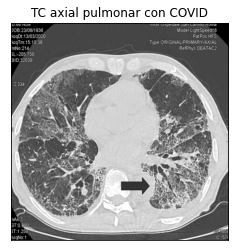

In [0]:
plt.title('TC axial pulmonar con COVID')
plt.imshow(train_img.get_fdata()[:,:,1].T,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

### Encontrando las menores dimensiones

In [0]:
min1 = 100000
min2 = 100000
for i in range(65):
  aux = train_img.get_fdata()[:,:,i]
  
  if  aux.shape[0] < min1:
    min1 = aux.shape[0]
  if aux.shape[1]<min2:
    min2 = aux.shape[1] 

In [0]:
print(f"La menor dimensión es {min2} x {min1}")

La menor dimensión es 512 x 512


# Leemos las imágenes SIN COVID

In [0]:
from skimage import  io
from skimage.transform import resize

In [0]:
Imagenes = os.listdir('./Imagenes_Sin_covid/')

In [0]:
Imagenes[0]

'IMG_25.png'

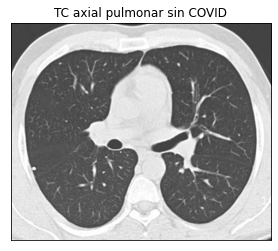

In [0]:
plt.title('TC axial pulmonar sin COVID')
plt.imshow(io.imread('./Imagenes_Sin_covid/'+Imagenes[7]),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Comparamos dimensiones


In [0]:
def Encuentra_la_menor_dim(names,ruta):

  min_C = 10000
  min_R = 10000
  
  for i in range(len(names)):
    aux  = io.imread(ruta+names[i],as_gray=True)

    if aux.shape[0] < min_R:
      min_R = aux.shape[0]
    if aux.shape[1] < min_C:
      min_C = aux.shape[1]
  return min_C,min_R

In [0]:
a,b=Encuentra_la_menor_dim(Imagenes,'./Imagenes_Sin_covid/')

In [0]:
print(f"La imágen más pequeña es de {b} x {a}")

La imágen más pequeña es de 188 x 233


In [0]:
def Redimensiona(imagen,shape):
    
    imagen = resize(imagen, shape, anti_aliasing=True)
    
    plt.title("Shape: "+str(imagen.shape))
    plt.imshow(imagen,cmap='gray')
    plt.xticks([])
    plt.yticks([])

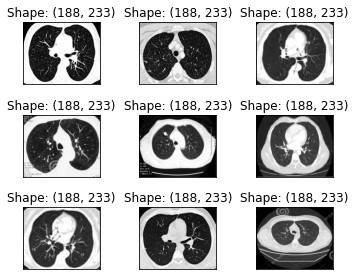

In [0]:
# Mostraremos sólo 10
plt.figure(figsize=(5,4))

for i in range(9):
  img = io.imread('./Imagenes_Sin_covid/'+Imagenes[i],as_gray=True)
  plt.subplot(3,3,i+1)
  Redimensiona(img,(b,a))
plt.tight_layout()
plt.show()

### Redimensionamos también las imagenes con Covid

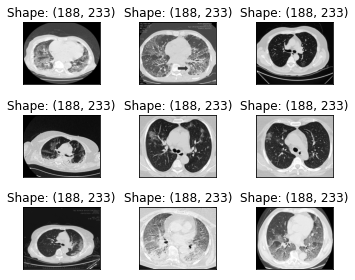

In [0]:
plt.figure(figsize=(5,4))
#Mostrando las 9 primeras
for i in range(9):
  img = train_img.get_fdata()[:,:,i].T
  plt.subplot(3,3,i+1)
  Redimensiona(img,(b,a))
plt.tight_layout()
plt.show()

# Creando y etiquetando

In [0]:
Sin_Cov = []
for imagen in Imagenes:
  img = io.imread('./Imagenes_Sin_covid/'+imagen,as_gray=True)
  img = resize(img, (b,a), anti_aliasing=True)
  img = img.reshape(1,-1)
  Sin_Cov.append(img)

In [0]:
Con_Cov = []
for imagen in range(len(Imagenes)):
  img = train_img.get_fdata()[:,:,i].T
  img = resize(img, (b,a), anti_aliasing=True)
  img = img.reshape(1,-1)
  Con_Cov.append(img)

In [0]:
X = []
Y = []
for i in range(len(Imagenes)):
  X.append(Sin_Cov[i][0])
  Y.append(0) # 0 = Sin Covid
for i in range(len(Imagenes)):
  X.append(Con_Cov[i][0])
  Y.append(1) # 1 = Con Covid

In [0]:
print("Comparando longitudes")
print(f"X = {len(X)}\nY = {len(Y)}")

Comparando longitudes
X = 128
Y = 128


# Dividiendo en conjuntos de entrenamiento y prueba

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=6)

# Aplicando KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
# Creamos el clasificador KNN con 2 vecinos
knn = KNeighborsClassifier(n_neighbors = 6)

In [0]:
Y_pred = knn.fit(X_train,y_train).predict(X_test)

### Verificando el reporte

In [0]:
from sklearn.metrics import classification_report

In [0]:
#KNN
report = classification_report(y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



# Mostrando Funcionamiento

In [0]:
Resultados = ({1:"Con Covid",0:"Sin Covid"})

In [0]:
import random as rd

In [0]:
def Funcionamiento(modelo):
  Imagen = rd.randint(0,len(Imagenes))
  aleatorio = rd.randint(0,1)
  
  if aleatorio == 1: # imagen con covid

    prueba = train_img.get_fdata()[:,:,Imagen].T

  else: # Imagen sin covid
    
    prueba = io.imread('./Imagenes_Sin_covid/'+Imagenes[Imagen],as_gray=True)

  prueba = resize(prueba, (b,a), anti_aliasing=True)
  prueba = prueba.reshape(1,-1)
  Resultado = modelo.predict(prueba) 

  print("Se eligió",Resultados.get(aleatorio))

  plt.title(Resultados.get(Resultado[0]))
  plt.imshow(prueba.reshape(b,a),cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()

Se eligió Con Covid


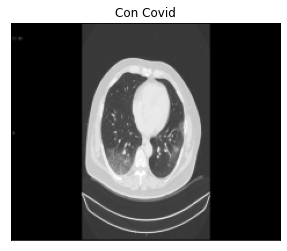

In [0]:
Funcionamiento(knn) # Esta línea se puede ejecutar n veces

# Aplicando Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
Bayes = GaussianNB()

In [0]:
Bayes.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
Y_pred = Bayes.predict(X_test)

### Generando el reporte

In [0]:
#Bayes
report = classification_report(y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



# Mostrando el funcionamiento

Se eligió Con Covid


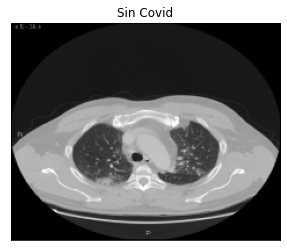

In [0]:
Funcionamiento(Bayes) # Esta línea se puede ejecutar n veces

# Aplicando Kmeans

In [0]:
from sklearn import cluster

In [0]:
kmeans = cluster.KMeans(n_clusters = 2 )

In [0]:
kmeans.fit(X_train,y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
Y_predict = kmeans.predict(X_test)

In [0]:
#K_means
Reporte = classification_report(y_test, Y_predict)
print(Reporte)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



Se eligió Sin Covid


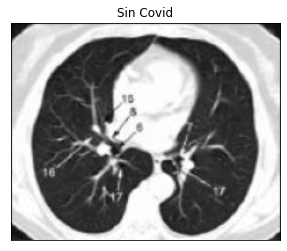

In [0]:
Funcionamiento(kmeans)

# Aplicando SVM

In [0]:
from sklearn.svm import SVC

In [0]:
svm = SVC()

In [0]:
svm.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
Y_pred = svm.predict(X_test)

In [0]:
#SVM
Reporte = classification_report(y_test, Y_pred)
print(Reporte)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



Se eligió Con Covid


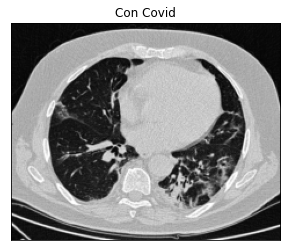

In [0]:
Funcionamiento(svm)